In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import os
import tqdm
import numpy as np
import numba
import dask

CPU_COUNT = os.cpu_count()
CPU_COUNT

8

In [2]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

In [3]:
test_coords = np.random.rand(100000, 2)

In [4]:
%timeit img = render(test_coords, 100)
img = render(test_coords, 100)

131 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


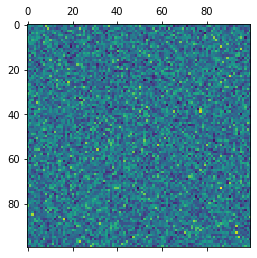

In [5]:
plt.matshow(img)

In [6]:
jit_render = numba.jit(render, nogil=True, nopython=True)

In [7]:
%timeit img2 = jit_render(test_coords, 100)
img2 = jit_render(test_coords, 100)

215 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
np.array_equal(img2, img)

True

In [9]:
test_coords_list = np.random.rand(CPU_COUNT, 100000, 2)

In [10]:
%time linear_compute = [jit_render(tc, 100) for tc in (test_coords_list)]

CPU times: user 2.9 ms, sys: 908 µs, total: 3.81 ms
Wall time: 2.9 ms


In [11]:
%time dask_compute = dask.compute([dask.delayed(jit_render)(tc, 100) for tc in test_coords_list], num_workers=16)

CPU times: user 9.48 ms, sys: 3.52 ms, total: 13 ms
Wall time: 13.6 ms


In [13]:
# %load_ext watermark
# %watermark
# print()
# %watermark -p dask,numpy,numba

# Coords generated internally

In [14]:
# import os
# import numpy as np
# import numba
# import dask

# CPU_COUNT = os.cpu_count()

def render_internal(size, mag):
    """mag is the magnification to apply
    generate coordinates internally
    """
    coords = np.random.rand(size, 2)
    img = np.zeros((mag, mag), dtype=np.int64)
    for i in range(size):
#         y0 = coords[0, i]
#         x0 = coords[1, i]
#         y1 = int(y0 * mag)
#         x1 = int(x0 * mag)
        m = 1
        img[0, 0] += m

jit_render_internal = numba.jit(render_internal, nogil=True, nopython=True)

args = 100000, 10

print("Linear time:")
%time linear_compute = [jit_render_internal(*args) for i in range(CPU_COUNT)]

delayed_jit_render_internal = dask.delayed(jit_render_internal)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="threads")

print()
print("Processes time:")
%time dask_compute_processes = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="processes")
        

Linear time:
CPU times: user 154 ms, sys: 10.9 ms, total: 165 ms
Wall time: 186 ms

Threads time:
CPU times: user 23.9 ms, sys: 6.41 ms, total: 30.3 ms
Wall time: 7.19 ms

Processes time:
CPU times: user 19.7 ms, sys: 29.4 ms, total: 49.1 ms
Wall time: 286 ms


In [15]:
import os
import numpy as np
import numba
import dask

CPU_COUNT = os.cpu_count()

def render_internal(size, mag):
    """mag is the magnification to apply
    generate coordinates internally
    """
    coords = np.zeros((size, 2))
    img = np.zeros((mag, mag), dtype=np.int64)
    for i in range(size):
#         y0 = np.random.rand() * mag
#         x0 = np.random.rand() * mag
        
        y0 = 0.0
        x0 = 0.0
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

jit_render_internal = numba.jit(render_internal, nogil=True, nopython=True)

args = 1000000, 10

print("Linear time:")
%time linear_compute = [jit_render_internal(*args) for i in range(CPU_COUNT)]

delayed_jit_render_internal = dask.delayed(jit_render_internal)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="threads")

print()
print("Processes time:")
%time dask_compute_processes = dask.compute(*[delayed_jit_render_internal(*args) for i in range(CPU_COUNT)], scheduler="processes")
        

Linear time:
CPU times: user 114 ms, sys: 19.2 ms, total: 133 ms
Wall time: 143 ms

Threads time:
CPU times: user 45 ms, sys: 83.8 ms, total: 129 ms
Wall time: 21.7 ms

Processes time:
CPU times: user 20.7 ms, sys: 29.5 ms, total: 50.2 ms
Wall time: 286 ms


In [18]:
import concurrent.futures

In [19]:
%%time
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Start the load operations and mark each future with its URL
    future_to_data = [executor.submit(jit_render_internal, *args) for i in range(48)]
    result = [future.result() for future in future_to_data]

CPU times: user 203 ms, sys: 142 ms, total: 346 ms
Wall time: 95.5 ms


In [20]:
%%time
# We can use a with statement to ensure threads are cleaned up promptly
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Start the load operations and mark each future with its URL
    future_to_data = [executor.submit(jit_render_internal, *args) for i in range(48)]
    result = [future.result() for future in future_to_data]

CPU times: user 67.3 ms, sys: 38.6 ms, total: 106 ms
Wall time: 136 ms


# Passed coords

In [21]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = np.random.rand(1000000, 2), 10

jit_render(*args)

print("Linear time:")
%time linear_compute = [jit_render(*args) for i in range(CPU_COUNT)]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*args) for i in range(CPU_COUNT)], scheduler="threads")

Linear time:
CPU times: user 18.2 ms, sys: 57 µs, total: 18.3 ms
Wall time: 18.1 ms

Threads time:
CPU times: user 30.5 ms, sys: 566 µs, total: 31.1 ms
Wall time: 5.69 ms


In [22]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0 = coords[i, 0] * mag
        x0 = coords[i, 1] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = [(np.random.rand(1000000, 2), 100) for i in range(CPU_COUNT)]

%timeit jit_render(*args[0])

print("Linear time:")
%time linear_compute = [jit_render(*a) for a in args]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*a) for a in args], scheduler="threads")

2.22 ms ± 74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Linear time:
CPU times: user 23.5 ms, sys: 322 µs, total: 23.8 ms
Wall time: 23.6 ms

Threads time:
CPU times: user 38.4 ms, sys: 797 µs, total: 39.2 ms
Wall time: 7.11 ms


In [23]:
def render(coords, mag):
    """Assumes coords is a N, 2 array where N is large and the numbers are between 0 and 1
    mag is the magnification to apply
    """
    img = np.zeros((mag, mag))
    for i in range(len(coords)):
        y0, x0 = coords[i] * mag
        y1 = int(y0)
        x1 = int(x0)
        m = 1
        img[y1, x1] += m

    return img

jit_render = numba.jit(render, nogil=True, nopython=True)

args = np.random.rand(1000000, 2), 10

jit_render(*args)

print("Linear time:")
%time linear_compute = [jit_render(*args) for i in range(CPU_COUNT)]

delayed_jit_render = dask.delayed(jit_render)

print()
print("Threads time:")
%time dask_compute_threads = dask.compute(*[delayed_jit_render(*args) for i in range(CPU_COUNT)], scheduler="threads")

Linear time:
CPU times: user 1.03 s, sys: 8.2 ms, total: 1.03 s
Wall time: 1.03 s

Threads time:
CPU times: user 8.04 s, sys: 11 ms, total: 8.05 s
Wall time: 1.05 s
